# Deniz's Notes

* 4.5 million from April to September 2014
* 14.3 million from January to June 2015 

In [1]:
#pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import datetime
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

In [3]:
%matplotlib inline

In [4]:
import os
cwd = os.getcwd()
cwd

'/home/dkardes/uber'

In [5]:
os.path.exists("/home/dkardes/uber/Uber-Jan-Feb-FOIL.csv")

True

In [6]:
df15 = pd.read_csv("~/uber/uber-trip-data/uber-raw-data-janjune-15.csv")
df15.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [7]:
df15.shape

(14270479, 4)

In [8]:
df15.isnull().any()

Dispatching_base_num    False
Pickup_date             False
Affiliated_base_num      True
locationID              False
dtype: bool

In [9]:
df15.isnull().sum()

Dispatching_base_num         0
Pickup_date                  0
Affiliated_base_num     162195
locationID                   0
dtype: int64

In [10]:
df15 = df15.dropna()

In [11]:
df15.isnull().sum()

Dispatching_base_num    0
Pickup_date             0
Affiliated_base_num     0
locationID              0
dtype: int64

In [12]:
df15.shape

(14108284, 4)

In [13]:
14270479-162195

14108284

In [14]:
# This file shows the taxi `Zone` and `Borough` for each `locationID`
taxi_zone = pd.read_csv("~/uber/uber-trip-data/taxi-zone-lookup.csv")
taxi_zone


,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights
...,...,...,...
260,261,Manhattan,World Trade Center
261,262,Manhattan,Yorkville East
262,263,Manhattan,Yorkville West
263,264,Unknown,Unknown


In [15]:
taxi_zone.groupby(["Borough"])["Zone"].count()

Borough
Bronx            43
Brooklyn         61
EWR               1
Manhattan        69
Queens           69
Staten Island    20
Unknown           2
Name: Zone, dtype: int64

### BaseCode | Base Name
    -------|---------
    B02512 | Unter
    B02598 | Hinter
    B02617 | Weiter
    B02682 | Schmecken
    B02764 | Danach-NY
    B02765 | Grun
    B02835 | Dreist
    B02836 | Drinnen

In [16]:
#Upload and group the files
files_2014 =['~/uber/uber-trip-data/uber-raw-data-apr14.csv',
                '~/uber/uber-trip-data/uber-raw-data-may14.csv',
                '~/uber/uber-trip-data/uber-raw-data-jun14.csv',
                '~/uber/uber-trip-data/uber-raw-data-jul14.csv',
                '~/uber/uber-trip-data/uber-raw-data-aug14.csv',
                '~/uber/uber-trip-data/uber-raw-data-sep14.csv']
df14 = pd.DataFrame()
for file in files_2014:
    df = pd.read_csv(file,encoding='utf-8')
    df14 = pd.concat([df,df14])

In [17]:
df14.shape

(4534327, 4)

In [18]:
df14.head()

,Date/Time,Lat,Lon,Base
0,9/1/2014 0:01:00,40.2201,-74.0021,B02512
1,9/1/2014 0:01:00,40.7500,-74.0027,B02512
2,9/1/2014 0:03:00,40.7559,-73.9864,B02512
3,9/1/2014 0:06:00,40.7450,-73.9889,B02512
4,9/1/2014 0:11:00,40.8145,-73.9444,B02512


In [19]:
df14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4534327 entries, 0 to 564515
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 173.0+ MB


In [20]:
df14.isnull().any()

Date/Time    False
Lat          False
Lon          False
Base         False
dtype: bool

In [21]:
df14.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

In [22]:
df14['Date/Time'] = pd.to_datetime(df14['Date/Time'], format="%m/%d/%Y %H:%M:%S")
df14['Year'] = df14['Date/Time'].dt.year #in case we want to merge the data from 2015.
df14['Month of Year'] = df14['Date/Time'].dt.month_name()
df14['Month'] = df14['Date/Time'].dt.month
df14['Days of Week'] = df14['Date/Time'].dt.day_name()
df14['Days of Month'] = df14['Date/Time'].dt.day
df14['Hour'] = df14['Date/Time'].dt.hour
df14['Minute'] = df14['Date/Time'].dt.minute
df14['Date'] = [d.date() for d in df14['Date/Time']]
df14['Time'] = [d.time() for d in df14['Date/Time']]

#df14['Date'] = pd.to_datetime(df14['Date/Time']).dt.date

In [23]:
df14.head()

,Date/Time,Lat,Lon,Base,Year,Month of Year,Month,Days of Week,Days of Month,Hour,Minute,Date,Time
0,2014-09-01 00:01:00,40.2201,-74.0021,B02512,2014,September,9,Monday,1,0,1,2014-09-01,00:01:00
1,2014-09-01 00:01:00,40.7500,-74.0027,B02512,2014,September,9,Monday,1,0,1,2014-09-01,00:01:00
2,2014-09-01 00:03:00,40.7559,-73.9864,B02512,2014,September,9,Monday,1,0,3,2014-09-01,00:03:00
3,2014-09-01 00:06:00,40.7450,-73.9889,B02512,2014,September,9,Monday,1,0,6,2014-09-01,00:06:00
4,2014-09-01 00:11:00,40.8145,-73.9444,B02512,2014,September,9,Monday,1,0,11,2014-09-01,00:11:00


In [24]:
#check for duplicates
df14.duplicated().sum()

82581

In [25]:
df14.drop_duplicates(inplace=True)

In [26]:
df14.shape

(4451746, 13)

In [49]:
df14["Date"].head()

0    2014-09-01
1    2014-09-01
2    2014-09-01
3    2014-09-01
4    2014-09-01
Name: Date, dtype: object

In [51]:
holiday = pd.read_csv("~/uber/date_holiday.txt")
holiday

,Date
0,2015-01-01
1,2015-01-19
2,2015-02-12
3,2015-02-16
4,2015-05-25
5,2015-06-19
6,2014-05-26
7,2014-06-19
8,2014-07-04
9,2014-09-01


In [42]:
holiday_status = []
for value in df14["Date"]:
    if value in holiday:
        holiday_status.append("1")
    else:
        holiday_status.append("0")
       
df14["holiday_status"] = holiday_status   
df14.head()

,Date/Time,Lat,Lon,Base,Year,Month of Year,Month,Days of Week,Days of Month,Hour,Minute,Date,Time,holiday_status
0,2014-09-01 00:01:00,40.2201,-74.0021,B02512,2014,September,9,Monday,1,0,1,2014-09-01,00:01:00,0
1,2014-09-01 00:01:00,40.7500,-74.0027,B02512,2014,September,9,Monday,1,0,1,2014-09-01,00:01:00,0
2,2014-09-01 00:03:00,40.7559,-73.9864,B02512,2014,September,9,Monday,1,0,3,2014-09-01,00:03:00,0
3,2014-09-01 00:06:00,40.7450,-73.9889,B02512,2014,September,9,Monday,1,0,6,2014-09-01,00:06:00,0
4,2014-09-01 00:11:00,40.8145,-73.9444,B02512,2014,September,9,Monday,1,0,11,2014-09-01,00:11:00,0


In [53]:
df14[df14["Date"]=="2014-09-01"].head()

,Date/Time,Lat,Lon,Base,Year,Month of Year,Month,Days of Week,Days of Month,Hour,Minute,Date,Time,holiday_status


# EDA

In [29]:
df14['Days of Week'].value_counts()

Thursday     741372
Friday       727532
Wednesday    683604
Tuesday      651753
Saturday     634194
Monday       532133
Sunday       481158
Name: Days of Week, dtype: int64

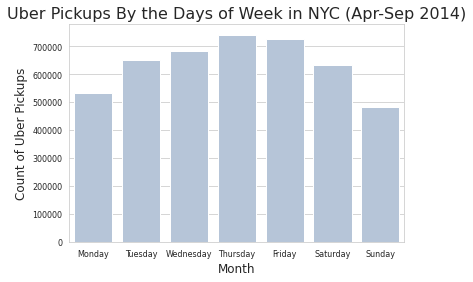

In [30]:
# Uber pickups by the month in NYC
sns.set_style('whitegrid')
ax = sns.countplot(x="Days of Week", data=df14, color="lightsteelblue")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Count of Uber Pickups', fontsize = 12)
ax.set_title('Uber Pickups By the Days of Week in NYC (Apr-Sep 2014)', fontsize=16)
ax.tick_params(labelsize = 8)
plt.show()

In [31]:
df14['Month'].value_counts()

9    1004099
8     813393
7     781969
6     653158
5     642360
4     556767
Name: Month, dtype: int64

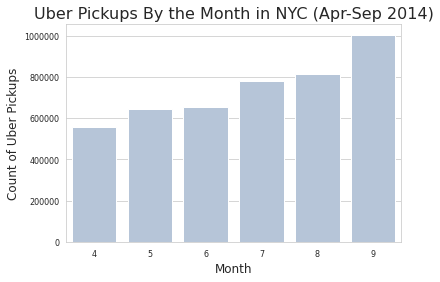

In [32]:
# Uber pickups by the month in NYC
sns.set_style('whitegrid')
ax = sns.countplot(x="Month", data=df14, color="lightsteelblue")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Count of Uber Pickups', fontsize = 12)
ax.set_title('Uber Pickups By the Month in NYC (Apr-Sep 2014)', fontsize=16)
ax.tick_params(labelsize = 8)
plt.show()

In [33]:
#group the data by Month of Years by Days of Week
summary1 = df14.groupby(['Month of Year', 'Days of Week'])['Time'].count()

In [34]:
#reset index
summary1 = summary1.reset_index()
#convert to dataframe
summary1 = pd.DataFrame(summary1)
#browse data
summary1.head()

,Month of Year,Days of Week,Time
0,April,Friday,88985
1,April,Monday,60075
2,April,Saturday,76152
3,April,Sunday,50524
4,April,Thursday,83954


In [35]:
#rename last column
summary1=summary1.rename(columns = {'Time':'Counts'})

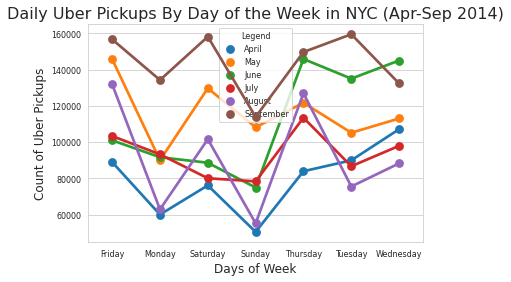

In [52]:
#Label needs to be added and x-axis needs to be rearranged.
sns.set_style('whitegrid')
ax = sns.pointplot(x="Days of Week", y="Counts", hue="Month of Year", data=summary1)
handles,labels = ax.get_legend_handles_labels()
labels = [labels[0], labels[4], labels[3], labels[2], labels[1], labels[5]]
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('Days of Week', fontsize = 12)
ax.set_ylabel('Count of Uber Pickups', fontsize = 12)
ax.set_title('Daily Uber Pickups By Day of the Week in NYC (Apr-Sep 2014)', fontsize=16)
ax.tick_params(labelsize = 8)
ax.legend(handles,labels,loc=0, title="Legend", prop={'size':8})
ax.get_legend().get_title().set_fontsize('8')
plt.show()

In [ ]:
handles,labels = ax.get_legend_handles_labels()
labels
#handles,labels = ax.get_legend_handles_labels()
#reordering legend content
#handles = [handles[1], handles[5], handles[6], handles[4], handles[0], handles[2], handles[3]]
labels = [labels[0], labels[4], labels[3], labels[2], labels[1], labels[5]]
sort= False

In [ ]:
df14.head()